<a href="https://colab.research.google.com/github/tanmayyb/screw-detector/blob/main/dataset_eda1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
import random
import json
import numpy as np
from skimage import io
from scipy import ndimage
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [9]:
cd 'gdrive/My Drive/screw_dataset/unpacked/'

/content/gdrive/My Drive/screw_dataset/unpacked


In [11]:
#os.listdir()
#with open('README_v1.0.txt') as f: print(f.read())

## Data Loading

In [12]:
#Load the json file with the annotation metadata
with open('mvtec_screws.json') as f:
  data = json.load(f)

print(data.keys())
print(data['images'][0])
print(data['annotations'][0])

dict_keys(['categories', 'images', 'annotations', 'licenses', 'info'])
{'file_name': 'screws_001.png', 'height': 1440, 'width': 1920, 'id': 1, 'license': 1}
{'area': 3440.97, 'bbox': [184.5, 876.313, 55, 62.5631, 0], 'category_id': 7, 'id': 1001, 'image_id': 1, 'is_crowd': 0}


In [13]:
#Make a dictionary (imgdict), and attach image metadata by image ID
imgdict  = {l['id']:l for l in data['images']}

In [14]:
#@title function for adding to dict 
"""
#adding to dict
abc = {1:{'id':1,'di':2}, 2:{'id':1,'di':2}}
print(abc.values())

for i in abc.values():
  i['img'] = 1

print(abc.values())
"""

"\n#adding to dict\nabc = {1:{'id':1,'di':2}, 2:{'id':1,'di':2}}\nprint(abc.values())\n\nfor i in abc.values():\n  i['img'] = 1\n\nprint(abc.values())\n"

In [15]:
#attach images to imgdict that contains metadata
for i in imgdict.values():
  i['image'] = io.imread(os.path.join('images', i['file_name']))[:,:,:3]

In [16]:
#@title set up `annodict` annotation dict

# remap annotations to dict by image_id
from collections import defaultdict
annodict = defaultdict(list)
for annotation in data['annotations']:
  annodict[annotation['image_id']].append(annotation)

# setup list of categories
categories = data['categories']
ncategories = len(categories)
cat_ids = [i['id'] for i in categories]

In [17]:
category_names = {7:'nut', 3:'wood screw', 2:'lag wood screw', 8:'bolt',
                  6:'black oxide screw', 5:'shiny screw', 4:'short wood screw',
                  1:'long lag screw', 9:'large nut', 11:'nut', 10:'nut',
                  12:'machine screw', 13:'short machine screw' }

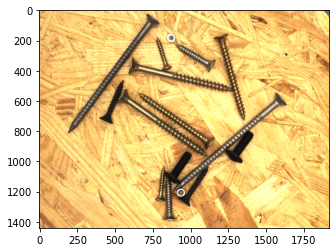

In [18]:
plt.imshow(imgdict[1]['image'][:,:])

In [19]:
#annodict[2]

## Checking out Data

In [30]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec
from matplotlib import patches, transforms as plt_transforms

rcParams['figure.figsize'] = [16, 6]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [36]:

def extract_subimg_bbox(im, bbox):
  return extract_subimg(im, *unpack_bbox(bbox))

def extract_subimg(im, rot_center, width, height, theta):
  rot_bbox = rotbbox_from_coords(rot_center, width, height, theta)

  subimg = im[rot_bbox[0,1]:rot_bbox[1,1],rot_bbox[0,0]:rot_bbox[1,0]]
  rotated_im = ndimage.rotate(subimg, np.degrees(theta)+180)
  newcenter = (np.array(rotated_im.shape)/2).astype(np.int)
  rotated_im = rotated_im[int(newcenter[0]-height/2):int(newcenter[0]+height/2), int(newcenter[1]-width/2):int(newcenter[1]+width/2), :3]  #drop alpha channel, if it's there

  return rotated_im

def rotbbox_from_coords(rot_center, width, height, theta):
  corner_points = rotcorners_from_coords(rot_center, width, height, theta)
  rot_bbox = np.array((corner_points.min(0), corner_points.max(0))).astype(np.int)
  #constrain inside image
  rot_bbox[rot_bbox < 0] = 0

  return rot_bbox

def rotcorners_from_coords(rot_center, width, height, theta):
  rotation = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta))))

  wvec = np.dot(rotation, (width/2, 0))
  hvec = np.dot(rotation, (0, height/2))
  corner_points = rot_center + [wvec+hvec, wvec-hvec, -wvec+hvec, -wvec-hvec]
  return corner_points

def unpack_bbox(bbox):
  #bbox as in the json/COCO data format (centerx, centery, width, height, theta is in radians)

  rot_center = np.array((bbox[1], bbox[0])).T
  width = bbox[3]
  height = bbox[2]
  theta = -bbox[4]+np.pi/2 #radians
  return rot_center, width, height, theta

In [38]:
annotation

{'area': 107011,
 'bbox': [488.63, 1389.16, 947, 113, 2.183292],
 'category_id': 2,
 'id': 100008,
 'image_id': 100,
 'is_crowd': 0}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.lau

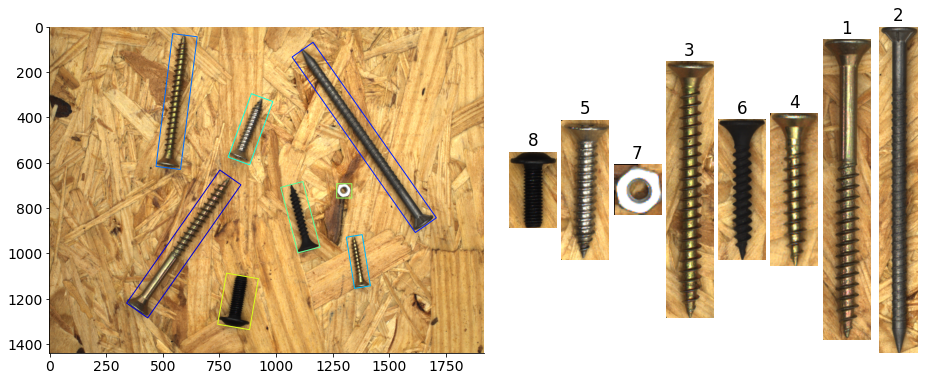

In [37]:
# Let's look at one image and it's associated annotations
imageid = 100
im = imgdict[imageid]['image']
gs = gridspec.GridSpec(1, 1 + len(annodict[imageid]),
                       width_ratios=[1,]+[.1]*len(annodict[imageid]),
                       wspace=.05)
plt.figure()
ax = plt.subplot(gs[0])
plt.imshow(im)
cmap_normal = plt.Normalize(0, ncategories)

for i, annotation in enumerate(annodict[imageid]):
  bbox = annotation['bbox'] # centerx, centery, width, height, theta is in radians

  ax = plt.subplot(gs[0])
  color = plt.cm.jet(cmap_normal(annotation['category_id']))
  
  rect = patches.Rectangle((bbox[1] - bbox[3]/2 ,   # centery - height/2
                            bbox[0] - bbox[2]/2),   # centerx - width/2 
                            bbox[3],                # height
                            bbox[2],                # width
                           linewidth=1, edgecolor=color, facecolor='none')
  
  t = plt_transforms.Affine2D().rotate_around(  bbox[1],            # centery 
                                                bbox[0],            # centerx
                                                -bbox[4]+np.pi/2)   # -theta + pi/2
  
  rect.set_transform(t + plt.gca().transData)
  ax.add_patch(rect)

  plt.subplot(gs[i + 1])
  rotated_im = extract_subimg_bbox(im, bbox)
  plt.imshow(rotated_im)
  plt.axis('off')
  plt.title(annotation['category_id'])
